In [18]:
### Packages

using Printf
using LinearAlgebra
using JLD
using QuadGK
using Statistics
using PyCall
using PyPlot
using LaTeXStrings
using GadgetIO
using GadgetUnits
using GadgetGalaxies
using UnitfulAstro
using Missings
using HypothesisTests
using Distributions

In [19]:
# Initial Parameters
snap_id = 136

# Derived
filepath = "/HydroSims/Magneticum/Box4/uhr_test/groups_$snap_id/sub_$snap_id"

"/HydroSims/Magneticum/Box4/uhr_test/groups_136/sub_136"

In [20]:
# Functions

# Rotate two vectors in a way that the third dimension is 0 for both
# sfc: check consistencies: Lengths, Angles
function nozaxis(vone,vtwo)
    start   = vone × vtwo
    start   = start ./ norm(start)
    finish  = [0,0,1]
    #fps     = finish+start

    vx      =  start × finish
    #println(vx)
    cx      = transpose(start) * finish
    Vx      = [0 -vx[3] vx[2]; vx[3] 0 -vx[1]; -vx[2] vx[1] 0]
    R = I + Vx + (Vx * Vx ./ (1+cx))

    return R*vone, R*vtwo
end

# Calculate the orbital angular momentum with respect to the central subhalo
function orbit_J(subm, subpos, subvel, cenpos, cenvel)
    return ((subpos .- cenpos) × (subvel .- cenvel)) .* subm
end


# Calculate Total Halo velocity
function halo_vel(m_ar, vel_ar)
    tot_vel = zeros(3)
    for i in 1:length(m_ar)
        tot_vel += m_ar[i] .* vel_ar[:,i]
    end
    tot_vel ./= sum(m_ar)
    return tot_vel
end

halo_vel (generic function with 1 method)

In [21]:
using Base: CacheHeaderIncludes, heads
# Read in

nsub        = read_subfind(filepath, "NSUB")
spinvecs    = read_subfind(filepath, "SPIN")
masses      = read_subfind(filepath, "MSUB")
smst        = read_subfind(filepath, "SMST")
spos        = read_subfind(filepath, "SPOS")
svel        = read_subfind(filepath, "SVEL")
scm         = read_subfind(filepath, "SCM")
mtot        = read_subfind(filepath, "MTOT")
gpos        = read_subfind(filepath, "GPOS")
head        = read_header(filepath)


# Check vectors
println("NSUB vector shape: ", size(nsub))
println("NSUB sum: ", sum(nsub))
println("SPIN vector shape: ", size(spinvecs))
println("SMST vector shape: ", size(smst))
println("SPOS vector shape: ", size(spos))
println("SVEL vector shape: ", size(svel))
println("SCM vector shape: ", size(scm))
println("MTOT vector shape: ", size(mtot))
println("GPOS vector shape: ", size(gpos))

println(Statistics.mean(spos .- scm))
println(Statistics.maximum(spos .- scm))
println(Statistics.minimum(spos .- scm))
println(Statistics.std(spos .- scm))


# Counting all the empty entries in nsub

nsubzeros = 0
for i in 1:length(nsub)
    if nsub[i] == 0
        nsubzeros += 1
    end
end

println(nsubzeros)
h = head.h0
println(typeof(head.h0))
println(h)
println("Redshift $(head.z)")

NSUB vector shape: (148471,)
NSUB sum: 166479
SPIN vector shape: (3, 166479)
SMST vector shape: (6, 166479)
SPOS vector shape: (3, 166479)
SVEL vector shape: (3, 166479)
SCM vector shape: (3, 166479)
MTOT vector shape: (148471,)
GPOS vector shape: (3, 148471)
-1.1494462
47998.844
-47998.848
332.64737
14098
Float64
0.704
Redshift 0.0663401914452304


In [22]:
# Processing

spins           = zeros(length(spinvecs[1,:]))
out_spins       = zeros(length(spins) - length(nsub) + nsubzeros)
out_masses      = zeros(length(spins) - length(nsub) + nsubzeros)
central_spins   = zeros(length(nsub))
central_masses  = zeros(length(nsub))
neighbors       = zeros(length(spins))
out_neighbors   = zeros(length(out_spins))
spin_stats      = zeros(2, length(nsub))
out_spin_stats  = zeros(2, length(nsub))
dmmasses        = convert_units_physical(smst[2,:], :mass, head)
halo_dmmasses   = convert_units_physical(mtot, :mass, head)

central_spinvecs    = zeros(3, length(nsub))
sum_out_spinvecs    = zeros(3, length(nsub))
sum_out_orbitvecs   = zeros(3,length(nsub))
#sum_out_orbitvecs   = missings(Float64, 3, length(nsub))
sum_out_orbits      = missings(Float64, length(nsub))
sum_out_spins       = zeros(length(nsub))
halo_vels           = zeros(3, length(nsub))
angles_cen_outsum   = missings(Float64, length(nsub))



for i in 1:length(spins)
    spins[i] = norm(spinvecs[:,i])
end

k = 0
for i in 1:length(nsub)
    central_spins[i]        = spins[k+1]
    central_masses[i]       = dmmasses[k+1]
    if dmmasses[k+1] > 0.0
        central_spinvecs[:,i]   = spinvecs[:,k+1] #./ dmmasses[k+1]
    end
    for j in 1:nsub[i]
        neighbors[j+k] = nsub[i] - 1
        if j > 1
            out_spins[j+k-i]        = spins[j+k]
            out_masses[j+k-i]       = dmmasses[j+k]
            out_neighbors[j+k-i]    = neighbors[j+k]
            if dmmasses[j+k] > 0.0
                sum_out_spinvecs[:,i]  += spinvecs[:,j+k] ./ dmmasses[j+k]
            end
            sum_out_orbitvecs[:,i] += orbit_J(dmmasses[j+k], spos[:,j+k], svel[:,j+k], spos[:,1+k], svel[:,1+k])
        end
    end
    sum_out_spins[i]        = norm(sum_out_spinvecs[:,i])
    sum_out_orbits[i]       = norm(sum_out_orbitvecs[:,i])
    if norm(central_spinvecs[:,i]) > 0.0 && norm(sum_out_orbitvecs[:,i]) > 0.0
        angles_cen_outsum[i]    = 180/π*acos((transpose(central_spinvecs[:,i])*sum_out_orbitvecs[:,i]) / norm(central_spinvecs[:,i]) / norm(sum_out_orbitvecs[:,i]))
    end
    
    k += nsub[i]
end


# Check vectors
println("Absolute spin vector shape: ", size(spins))
println("Neighbors vector shape: ", size(neighbors))
println("Spin stats vector shape: ", size(spin_stats))
println("Outer spins shape: ", size(out_spins))
println("Missing ")



Absolute spin vector shape: (166479,)
Neighbors vector shape: (166479,)
Spin stats vector shape: (2, 148471)
Outer spins shape: (32106,)
Missing 


In [23]:
println(sum_out_orbitvecs[:,408])
println(angles_cen_outsum[408])

[0.0, 0.0, 0.0]
missing


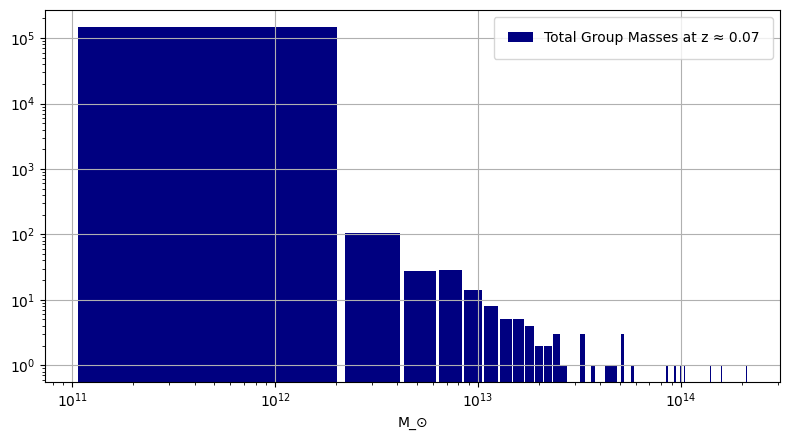

1.6529176e9
2.1096846e14
3.3851482e9


In [24]:
# Plotting the masses

fig, ax = subplots()

ax.hist(halo_dmmasses, bins=100, label="Total Group Masses at z ≈ $(@sprintf("%.2f", head.z))", rwidth=0.9, color="navy")

ax.set_xlabel("M_⊙")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax.grid()

scale=0.5

fig.set_size_inches(16scale, 9scale)
fig.tight_layout()

println(minimum(halo_dmmasses))
println(maximum(halo_dmmasses))
println(Statistics.median(halo_dmmasses))
fig.savefig(joinpath(@__DIR__, "masses_z$(@sprintf("%.2f", head.z)).png"), bbox_inches="tight", pad_inches=.1)

In [25]:
# Mass separation

mlim1   = 1.0e12
mlim2   = 1.0e13

smalls  = Dict("ID"=>Array{Int64}(undef, 0), "MASS"=>Array{Float64}(undef, 0), "ANG"=>Array{Float64}(undef, 0))
mediums = Dict("ID"=>Array{Int64}(undef, 0), "MASS"=>Array{Float64}(undef, 0), "ANG"=>Array{Float64}(undef, 0))
bigs    = Dict("ID"=>Array{Int64}(undef, 0), "MASS"=>Array{Float64}(undef, 0), "ANG"=>Array{Float64}(undef, 0))
for i in 1:length(halo_dmmasses)
    if ismissing(angles_cen_outsum[i])
    elseif halo_dmmasses[i] > 0.0 && halo_dmmasses[i] < mlim1
        smalls["ID"]    = vcat(smalls["ID"], i)
        smalls["MASS"]  = vcat(smalls["MASS"], halo_dmmasses[i])
        smalls["ANG"]   = vcat(smalls["ANG"], angles_cen_outsum[i])
    elseif halo_dmmasses[i] > mlim1 && halo_dmmasses[i] < mlim2
        mediums["ID"]    = vcat(mediums["ID"], i)
        mediums["MASS"]  = vcat(mediums["MASS"], halo_dmmasses[i])
        mediums["ANG"]   = vcat(mediums["ANG"], angles_cen_outsum[i])
    elseif halo_dmmasses[i] > mlim2
        bigs["ID"]    = vcat(bigs["ID"], i)
        bigs["MASS"]  = vcat(bigs["MASS"], halo_dmmasses[i])
        bigs["ANG"]   = vcat(bigs["ANG"], angles_cen_outsum[i])
    end
end
println("Number of small Halos: $(size(smalls["ANG"]))")
println("Number of medium Halos: $(size(mediums["ANG"]))")
println("Number of big Halos: $(size(bigs["ANG"]))")

Number of small Halos: (6155,)
Number of medium Halos: (400,)
Number of big Halos: (50,)


In [26]:
# Expected distributions

xaxis_angles    = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 105, 115, 125, 135, 145, 155, 165, 175]
smalls_expect   = sin.(xaxis_angles .* (π/180))
smalls_expect ./= sum(smalls_expect)
smalls_expect .*= size(smalls["ANG"])

mediums_expect   = sin.(xaxis_angles .* (π/180))
mediums_expect ./= sum(mediums_expect)
mediums_expect .*= size(mediums["ANG"])

bigs_expect   = sin.(xaxis_angles .* (π/180))
bigs_expect ./= sum(bigs_expect)
bigs_expect .*= size(bigs["ANG"])

println(sum(smalls_expect), "   ", size(smalls["ANG"]))
println(sum(mediums_expect), "   ", size(mediums["ANG"]))
println(sum(bigs_expect), "   ", size(bigs["ANG"]))

6155.000000000001   (6155,)
400.00000000000006   (400,)
50.00000000000001   (50,)


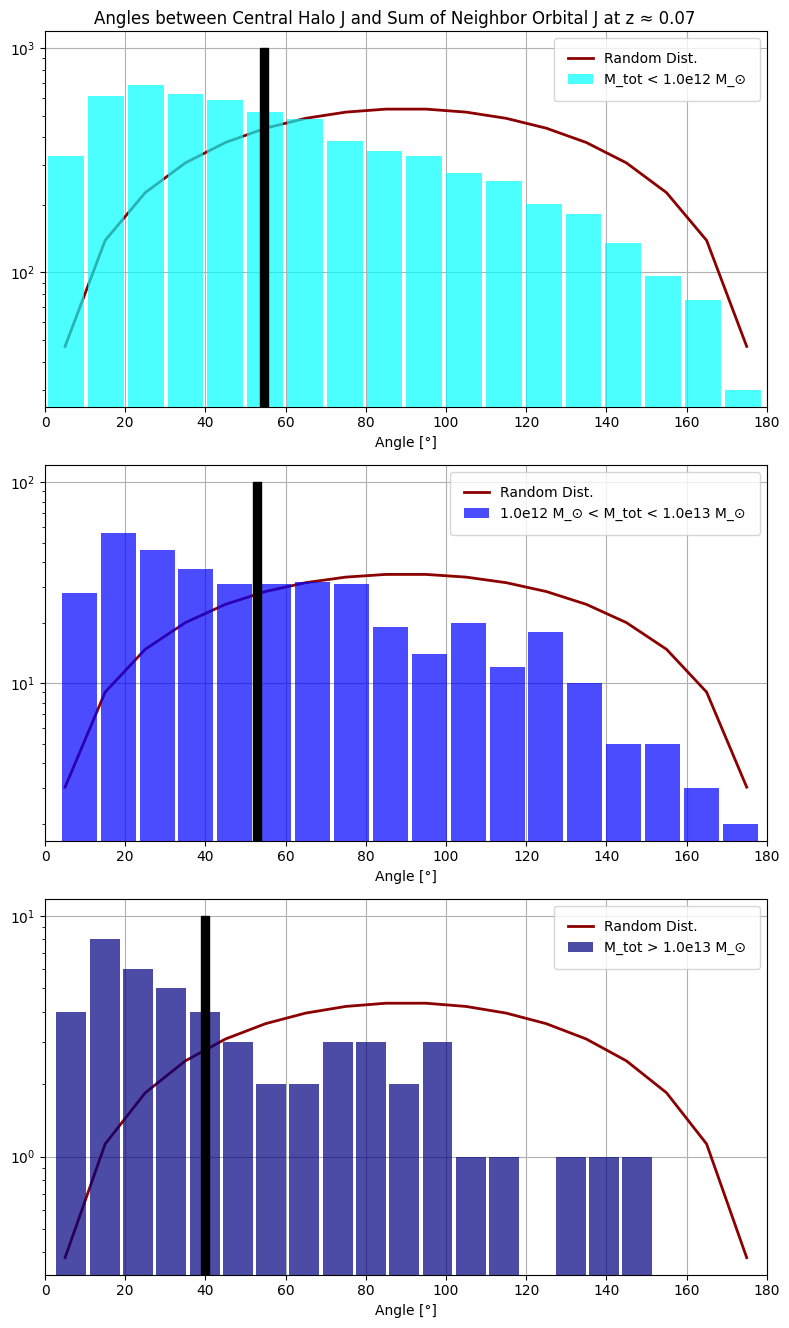

In [27]:
# Plotting the masses

N_plots = 3
qt      = 0.68
scale   = 0.5
fig, ax = subplots(N_plots)

ax[1].plot(xaxis_angles, smalls_expect, "-", lw=2, color="darkred", label="Random Dist.", zorder=2, alpha=1)
ax[1].hist(smalls["ANG"], bins=18, label="M_tot < $mlim1 M_⊙", rwidth=0.9, color="cyan", alpha=0.7, zorder = 3)
ax[1].bar(Statistics.median(smalls["ANG"]), height=1e3, width=2, edgecolor="black", color="black", zorder=7)
ax[1].set_xlabel("Angle [°]")
ax[1].set_xbound(0,180)
ax[1].set_yscale("log")
ax[1].legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax[1].grid()

ax[2].plot(xaxis_angles, mediums_expect, "-", lw=2, color="darkred", label="Random Dist.", zorder=3, alpha=1)
ax[2].hist(mediums["ANG"], bins=18, label="$mlim1 M_⊙ < M_tot < $mlim2 M_⊙", rwidth=0.9, color="blue", alpha=0.7, zorder = 4)
ax[2].bar(Statistics.median(mediums["ANG"]), height=1e2, width=2, edgecolor="black", color="black", zorder=8)
ax[2].set_xlabel("Angle [°]")
ax[2].set_xbound(0,180)
ax[2].set_yscale("log")
ax[2].legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax[2].grid()

ax[3].plot(xaxis_angles, bigs_expect, "-", lw=2, color="darkred", label="Random Dist.", zorder=5, alpha=1)
ax[3].hist(bigs["ANG"], bins=18, label="M_tot > $mlim2 M_⊙", rwidth=0.9, color="navy", alpha=0.7, zorder = 6)
ax[3].bar(Statistics.median(bigs["ANG"]), height=1e1, width=2, edgecolor="black", color="black", zorder=9)
ax[3].set_xlabel("Angle [°]")
ax[3].set_xbound(0,180)
ax[3].set_yscale("log")
ax[3].legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax[3].grid()

fig.suptitle("Angles between Central Halo J and Sum of Neighbor Orbital J at z ≈ $(@sprintf("%.2f", head.z))")
fig.set_size_inches(16scale, 9scale*N_plots)
fig.tight_layout()
fig.savefig(joinpath(@__DIR__, "cen_v_orbit_z$(@sprintf("%.2f", head.z)).png"), bbox_inches="tight", pad_inches=.1)

# Repeat for high z

NSUB vector shape: (161535,)
NSUB sum: 172881
SPIN vector shape: (3, 172881)
SMST vector shape: (6, 172881)
SPOS vector shape: (3, 172881)
SVEL vector shape: (3, 172881)
SCM vector shape: (3, 172881)
MTOT vector shape: (161535,)
GPOS vector shape: (3, 161535)
-0.45729408
47999.1
-47999.9
456.7539
8728
Float64
0.704
Redshift 1.9800821404941926
Absolute spin vector shape: (172881,)
Neighbors vector shape: (172881,)
Spin stats vector shape: (2, 161535)
Outer spins shape: (20074,)
Missing 
1.6529178e9
2.3828317e13
3.5239493e9
1.6529178e9
2.3828317e13
3.5239493e9
Number of small Halos: (5360,)

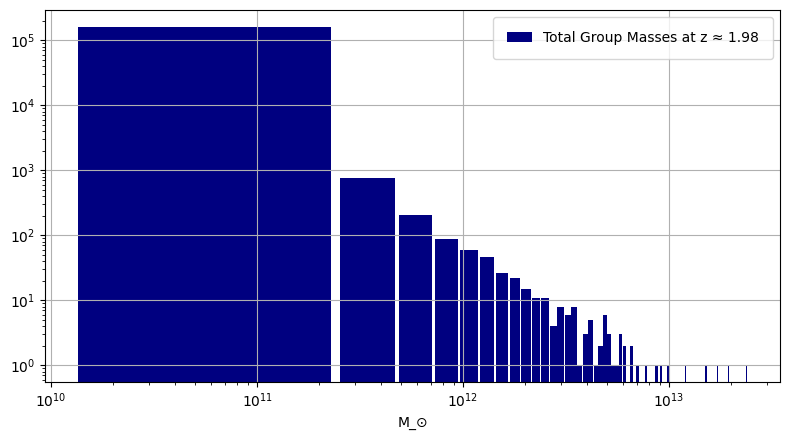

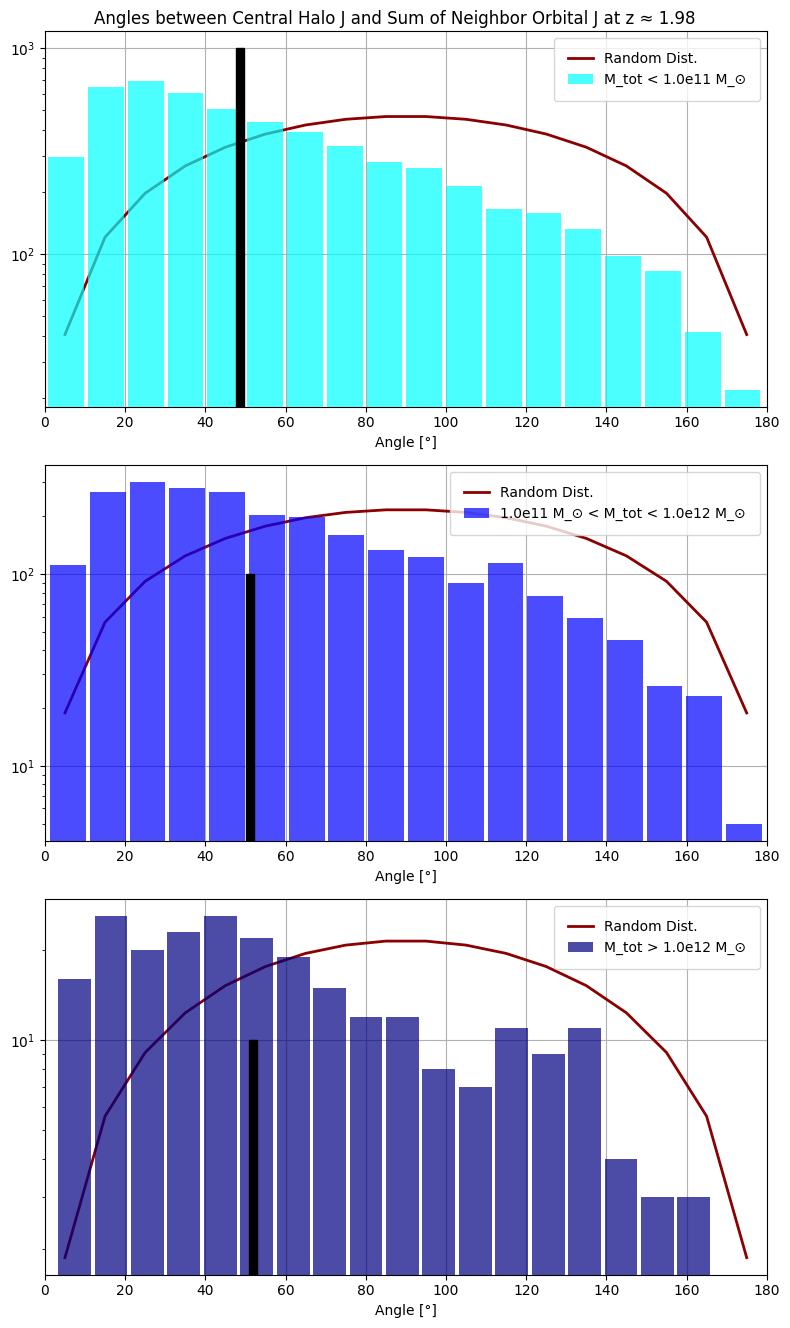


Number of medium Halos: (2485,)
Number of big Halos: (247,)
5360.0   (5360,)
2485.0   (2485,)
247.0   (247,)


In [28]:
# Initial Parameters
snap_id = 36

# Derived
filepath = "/HydroSims/Magneticum/Box4/uhr_test/groups_0$snap_id/sub_0$snap_id"

using Base: CacheHeaderIncludes, heads
# Read in

nsub        = read_subfind(filepath, "NSUB")
spinvecs    = read_subfind(filepath, "SPIN")
masses      = read_subfind(filepath, "MSUB")
smst        = read_subfind(filepath, "SMST")
spos        = read_subfind(filepath, "SPOS")
svel        = read_subfind(filepath, "SVEL")
scm         = read_subfind(filepath, "SCM")
mtot        = read_subfind(filepath, "MTOT")
gpos        = read_subfind(filepath, "GPOS")
head        = read_header(filepath)


# Check vectors
println("NSUB vector shape: ", size(nsub))
println("NSUB sum: ", sum(nsub))
println("SPIN vector shape: ", size(spinvecs))
println("SMST vector shape: ", size(smst))
println("SPOS vector shape: ", size(spos))
println("SVEL vector shape: ", size(svel))
println("SCM vector shape: ", size(scm))
println("MTOT vector shape: ", size(mtot))
println("GPOS vector shape: ", size(gpos))

println(Statistics.mean(spos .- scm))
println(Statistics.maximum(spos .- scm))
println(Statistics.minimum(spos .- scm))
println(Statistics.std(spos .- scm))


# Counting all the empty entries in nsub

nsubzeros = 0
for i in 1:length(nsub)
    if nsub[i] == 0
        nsubzeros += 1
    end
end

println(nsubzeros)
h = head.h0
println(typeof(head.h0))
println(h)
println("Redshift $(head.z)")

# Processing

spins           = zeros(length(spinvecs[1,:]))
out_spins       = zeros(length(spins) - length(nsub) + nsubzeros)
out_masses      = zeros(length(spins) - length(nsub) + nsubzeros)
central_spins   = zeros(length(nsub))
central_masses  = zeros(length(nsub))
neighbors       = zeros(length(spins))
out_neighbors   = zeros(length(out_spins))
spin_stats      = zeros(2, length(nsub))
out_spin_stats  = zeros(2, length(nsub))
dmmasses        = convert_units_physical(smst[2,:], :mass, head)
halo_dmmasses   = convert_units_physical(mtot, :mass, head)

central_spinvecs    = zeros(3, length(nsub))
sum_out_spinvecs    = zeros(3, length(nsub))
sum_out_orbitvecs   = zeros(3,length(nsub))
#sum_out_orbitvecs   = missings(Float64, 3, length(nsub))
sum_out_orbits      = missings(Float64, length(nsub))
sum_out_spins       = zeros(length(nsub))
halo_vels           = zeros(3, length(nsub))
angles_cen_outsum   = missings(Float64, length(nsub))



for i in 1:length(spins)
    spins[i] = norm(spinvecs[:,i])
end

k = 0
for i in 1:length(nsub)
    central_spins[i]        = spins[k+1]
    central_masses[i]       = dmmasses[k+1]
    if dmmasses[k+1] > 0.0
        central_spinvecs[:,i]   = spinvecs[:,k+1] #./ dmmasses[k+1]
    end
    for j in 1:nsub[i]
        neighbors[j+k] = nsub[i] - 1
        if j > 1
            out_spins[j+k-i]        = spins[j+k]
            out_masses[j+k-i]       = dmmasses[j+k]
            out_neighbors[j+k-i]    = neighbors[j+k]
            if dmmasses[j+k] > 0.0
                sum_out_spinvecs[:,i]  += spinvecs[:,j+k] ./ dmmasses[j+k]
            end
            sum_out_orbitvecs[:,i] += orbit_J(dmmasses[j+k], spos[:,j+k], svel[:,j+k], spos[:,1+k], svel[:,1+k])
        end
    end
    sum_out_spins[i]        = norm(sum_out_spinvecs[:,i])
    sum_out_orbits[i]       = norm(sum_out_orbitvecs[:,i])
    if norm(central_spinvecs[:,i]) > 0.0 && norm(sum_out_orbitvecs[:,i]) > 0.0
        angles_cen_outsum[i]    = 180/π*acos((transpose(central_spinvecs[:,i])*sum_out_orbitvecs[:,i]) / norm(central_spinvecs[:,i]) / norm(sum_out_orbitvecs[:,i]))
    end
    
    k += nsub[i]
end


# Check vectors
println("Absolute spin vector shape: ", size(spins))
println("Neighbors vector shape: ", size(neighbors))
println("Spin stats vector shape: ", size(spin_stats))
println("Outer spins shape: ", size(out_spins))
println("Missing ")

# Plotting the masses

fig, ax = subplots()

ax.hist(halo_dmmasses, bins=100, label="Total Group Masses at z ≈ $(@sprintf("%.2f", head.z))", rwidth=0.9, color="navy")

ax.set_xlabel("M_⊙")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax.grid()

scale=0.5

fig.set_size_inches(16scale, 9scale)
fig.tight_layout()

println(minimum(halo_dmmasses))
println(maximum(halo_dmmasses))
println(Statistics.median(halo_dmmasses))
fig.savefig(joinpath(@__DIR__, "masses_z$(@sprintf("%.2f", head.z)).png"), bbox_inches="tight", pad_inches=.1)

println(minimum(halo_dmmasses))
println(maximum(halo_dmmasses))
println(Statistics.median(halo_dmmasses))

# Mass separation

mlim1   = 1.0e11
mlim2   = 1.0e12

smalls  = Dict("ID"=>Array{Int64}(undef, 0), "MASS"=>Array{Float64}(undef, 0), "ANG"=>Array{Float64}(undef, 0))
mediums = Dict("ID"=>Array{Int64}(undef, 0), "MASS"=>Array{Float64}(undef, 0), "ANG"=>Array{Float64}(undef, 0))
bigs    = Dict("ID"=>Array{Int64}(undef, 0), "MASS"=>Array{Float64}(undef, 0), "ANG"=>Array{Float64}(undef, 0))
for i in 1:length(halo_dmmasses)
    if ismissing(angles_cen_outsum[i])
    elseif halo_dmmasses[i] > 0.0 && halo_dmmasses[i] < mlim1
        smalls["ID"]    = vcat(smalls["ID"], i)
        smalls["MASS"]  = vcat(smalls["MASS"], halo_dmmasses[i])
        smalls["ANG"]   = vcat(smalls["ANG"], angles_cen_outsum[i])
    elseif halo_dmmasses[i] > mlim1 && halo_dmmasses[i] < mlim2
        mediums["ID"]    = vcat(mediums["ID"], i)
        mediums["MASS"]  = vcat(mediums["MASS"], halo_dmmasses[i])
        mediums["ANG"]   = vcat(mediums["ANG"], angles_cen_outsum[i])
    elseif halo_dmmasses[i] > mlim2
        bigs["ID"]    = vcat(bigs["ID"], i)
        bigs["MASS"]  = vcat(bigs["MASS"], halo_dmmasses[i])
        bigs["ANG"]   = vcat(bigs["ANG"], angles_cen_outsum[i])
    end
end
println("Number of small Halos: $(size(smalls["ANG"]))")
println("Number of medium Halos: $(size(mediums["ANG"]))")
println("Number of big Halos: $(size(bigs["ANG"]))")

# Expected distributions

xaxis_angles    = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 105, 115, 125, 135, 145, 155, 165, 175]
smalls_expect   = sin.(xaxis_angles .* (π/180))
smalls_expect ./= sum(smalls_expect)
smalls_expect .*= size(smalls["ANG"])

mediums_expect   = sin.(xaxis_angles .* (π/180))
mediums_expect ./= sum(mediums_expect)
mediums_expect .*= size(mediums["ANG"])

bigs_expect   = sin.(xaxis_angles .* (π/180))
bigs_expect ./= sum(bigs_expect)
bigs_expect .*= size(bigs["ANG"])

println(sum(smalls_expect), "   ", size(smalls["ANG"]))
println(sum(mediums_expect), "   ", size(mediums["ANG"]))
println(sum(bigs_expect), "   ", size(bigs["ANG"]))

# Plotting the masses


N_plots = 3
qt      = 0.68
scale   = 0.5
fig, ax = subplots(N_plots)

ax[1].plot(xaxis_angles, smalls_expect, "-", lw=2, color="darkred", label="Random Dist.", zorder=2, alpha=1)
ax[1].hist(smalls["ANG"], bins=18, label="M_tot < $mlim1 M_⊙", rwidth=0.9, color="cyan", alpha=0.7, zorder = 3)
ax[1].bar(Statistics.median(smalls["ANG"]), height=1e3, width=2, edgecolor="black", color="black", zorder=7)
ax[1].set_xlabel("Angle [°]")
ax[1].set_xbound(0,180)
ax[1].set_yscale("log")
ax[1].legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax[1].grid()

ax[2].plot(xaxis_angles, mediums_expect, "-", lw=2, color="darkred", label="Random Dist.", zorder=3, alpha=1)
ax[2].hist(mediums["ANG"], bins=18, label="$mlim1 M_⊙ < M_tot < $mlim2 M_⊙", rwidth=0.9, color="blue", alpha=0.7, zorder = 4)
ax[2].bar(Statistics.median(mediums["ANG"]), height=1e2, width=2, edgecolor="black", color="black", zorder=8)
ax[2].set_xlabel("Angle [°]")
ax[2].set_xbound(0,180)
ax[2].set_yscale("log")
ax[2].legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax[2].grid()

ax[3].plot(xaxis_angles, bigs_expect, "-", lw=2, color="darkred", label="Random Dist.", zorder=5, alpha=1)
ax[3].hist(bigs["ANG"], bins=18, label="M_tot > $mlim2 M_⊙", rwidth=0.9, color="navy", alpha=0.7, zorder = 6)
ax[3].bar(Statistics.median(bigs["ANG"]), height=1e1, width=2, edgecolor="black", color="black", zorder=9)
ax[3].set_xlabel("Angle [°]")
ax[3].set_xbound(0,180)
ax[3].set_yscale("log")
ax[3].legend(loc="upper right", frameon=true, borderpad=1, handlelength=1.8)
ax[3].grid()

fig.suptitle("Angles between Central Halo J and Sum of Neighbor Orbital J at z ≈ $(@sprintf("%.2f", head.z))")
fig.set_size_inches(16scale, 9scale*N_plots)
fig.tight_layout()
fig.savefig(joinpath(@__DIR__, "cen_v_orbit_z$(@sprintf("%.2f", head.z)).png"), bbox_inches="tight", pad_inches=.1)

In [29]:
function orbit_J2(snapID, subID, box="/HydroSims/Magneticum/Box4/uhr_test")
    # Find central sub
    pathtofile  = "$box/groups_$(@sprintf("%03i", snapID))/sub_$(@sprintf("%03i", snapID))"    
    head        = read_header(pathtofile)
    nsub        = read_subfind(pathtofile, "NSUB")
    centID      = 0
    for f in 1:length(nsub)
        if subID > centID+nsub[f]
            centID += nsub[f]
        else
            break
        end
    end
    println(centID)
    smst        = convert_units_physical(read_subfind(pathtofile, "SMST"), :mass, head)
    spos        = convert_units_physical(read_subfind(pathtofile, "SPOS"), :pos, head)
    svel        = convert_units_physical(read_subfind(pathtofile, "SVEL"), :vel, head)
    halo_dmmasses   = convert_units_physical(mtot, :mass, head)
    return ((spos[:,subID+1] .- spos[:,centID+1]) × (svel[:,subID+1] .- svel[:,centID+1])) .* smst[subID+1]
end

println(snap_id)
println(orbit_J2(136, 4000))

36
3968
Float32[1.6996137f13, 6.109795f12, -5.776893f12]
